In [26]:
import sqlite3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import os

In [27]:
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
c = conn.cursor()

In [28]:
c.execute('SELECT * FROM journeys')
df = gpd.GeoDataFrame(c.fetchall(), columns=['id', 'total_duration', 'start_datetime', 'end_datetime', 'gec', 'nox_pm', 'method_1', 'method_2', 'path'])
df['gec'] = df['gec'].apply(lambda x: json.loads(x))
df['nox_pm'] = df['nox_pm'].apply(lambda x: json.loads(x))
df['path'] = df['path'].apply(lambda x: json.loads(x))
df['method_1'] = df['method_1'].apply(lambda x: json.loads(x))
df['method_2'] = df['method_2'].apply(lambda x: json.loads(x))
df.head()

,id,total_duration,start_datetime,end_datetime,gec,nox_pm,method_1,method_2,path
0,1,2972,20240525T175138,20240525T184110,"{'value': 933.1212, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2972, 'walking': 1232, 'bike': 0, 'c...","{'walking': 272, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Liberté', 'arrival_date_time'..."
1,2,2636,20240525T173733,20240525T182129,"{'value': 380.232, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2636, 'walking': 1436, 'bike': 0, 'c...","{'walking': 612, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Pont de La Mulatière', 'arriv..."
2,3,3025,20240525T174745,20240525T183810,"{'value': 558.0722, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3025, 'walking': 1945, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."
3,4,3685,20240525T174745,20240525T184910,"{'value': 726.4134, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1585, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."
4,5,3685,20240525T174745,20240525T184910,"{'value': 705.801, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1525, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d..."


In [29]:
c.execute('SELECT * FROM stops')
stops_df = gpd.GeoDataFrame(c.fetchall(), columns=['stop_id', 'stop_name', 'lon_lat', 'accessibility'])
stops_df['lon_lat'] = stops_df['lon_lat'].apply(lambda x: json.loads(x))
stops_df.head()

,stop_id,stop_name,lon_lat,accessibility
0,stop_point:tcl:SP:32113,Liberté,"{'lon': '4.842381', 'lat': '45.758852'}","[""has_wheelchair_boarding""]"
1,stop_point:tcl:SP:32111,Guillotière Gabriel Péri,"{'lon': '4.842434', 'lat': '45.754935'}","[""has_wheelchair_boarding""]"
2,stop_point:tcl:SP:30200,Guillotière Gabriel Péri,"{'lon': '4.84252', 'lat': '45.75541'}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
3,stop_point:tcl:SP:30202,Bellecour,"{'lon': '4.833822', 'lat': '45.756711'}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
4,stop_point:tcl:SP:45799,Bellecour Le Viste,"{'lon': '4.833739', 'lat': '45.757154'}","[""has_wheelchair_boarding""]"


In [30]:
# if journeys.csv has already been created, don't do it again

if os.path.isfile('journeys.csv'):
    print('Journey distance file already exists, using that instead')
    df1 = pd.read_csv('journeys.csv')
    df['distance'] = pd.read_csv('journeys.csv')['distance']
# otherwise, calculate the distance for each journey
else:
    # calculate the distance of each journey
    # https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    # returns the distance in meters
    def coord_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """
        Given two coordinates, returns the distance between them in meters.
        Args:
            lat1 (float): latitude of the first point
            lon1 (float): longitude of the first point
            lat2 (float): latitude of the second point
            lon2 (float): longitude of the second point
            
        Returns:
            float: distance between the two points in meters
        """
        R = 6371e3
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        d = R * c
        return d
    
    distances = []
    n = 0
    done = len(df)
    start_time = time.time()
    for i, row in df.iterrows():
        path = row['path']
        distance = 0
        for i in range(len(path) - 1):
            start = path[i]['stop_point']
            end = path[i+1]['stop_point']
            
            start_coords = stops_df[stops_df['stop_name'] == start]['lon_lat'].values[0]
            end_coords = stops_df[stops_df['stop_name'] == end]['lon_lat'].values[0]
            distance += coord_distance(float(start_coords['lon']), float(start_coords['lat']), float(end_coords['lon']), float(end_coords['lat']))
        distances.append(distance)
        n += 1
        # print percentage done and time taken
        if n % 10000 == 0:
            print(f'{n}/{done} ({n/done*100:.2f}%)')
            print(f'{(done-n)/n*(time.time()-start_time)/60:.2f} minutes remaining')
        break
    df['distance'] = distances

    # save the data to a csv so I never have to do this again
    df['distance'].to_csv('journeys.csv')

Journey distance file already exists, using that instead


In [31]:
df.head()

,id,total_duration,start_datetime,end_datetime,gec,nox_pm,method_1,method_2,path,distance
0,1,2972,20240525T175138,20240525T184110,"{'value': 933.1212, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2972, 'walking': 1232, 'bike': 0, 'c...","{'walking': 272, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Liberté', 'arrival_date_time'...",7230.325009
1,2,2636,20240525T173733,20240525T182129,"{'value': 380.232, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2636, 'walking': 1436, 'bike': 0, 'c...","{'walking': 612, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Pont de La Mulatière', 'arriv...",9124.219471
2,3,3025,20240525T174745,20240525T183810,"{'value': 558.0722, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3025, 'walking': 1945, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7287.909338
3,4,3685,20240525T174745,20240525T184910,"{'value': 726.4134, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1585, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7085.043248
4,5,3685,20240525T174745,20240525T184910,"{'value': 705.801, 'unit': 'gEC'}","{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1525, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",6733.550704


In [32]:
# remove rows that are outliers in terms of total_duration
q1 = df['total_duration'].quantile(0.25)
q3 = df['total_duration'].quantile(0.75)
iqr = q3 - q1
df = df[(df['total_duration'] > (q1 - 1.5 * iqr)) & (df['total_duration'] < (q3 + 1.5 * iqr))]

# remove rows that are outliers in terms of distance
q1 = df['distance'].quantile(0.25)
q3 = df['distance'].quantile(0.75)
iqr = q3 - q1
df = df[(df['distance'] > (q1 - 1.5 * iqr)) & (df['distance'] < (q3 + 1.5 * iqr))]
print('Distance mean:', np.mean(df['distance']))
print('Distance median:', np.median(df['distance']))
print('Distance std:', np.std(df['distance']))

# gEC per km
df['gec'] = df['gec'].apply(lambda x: x['value'])
df['gec_per_km'] = df['gec'] / df['distance']

# remove rows that are outliers in terms of gec_per_km
q1 = df['gec_per_km'].quantile(0.25)
q3 = df['gec_per_km'].quantile(0.75)
iqr = q3 - q1
df = df[(df['gec_per_km'] > (q1 - 1.5 * iqr)) & (df['gec_per_km'] < (q3 + 1.5 * iqr))]

# convert distance to km
df['distance'] = df['distance'] / 1000
df.head()

Distance mean: 8084.709218047177
Distance median: 7859.768530139589
Distance std: 3570.129425389021


,id,total_duration,start_datetime,end_datetime,gec,nox_pm,method_1,method_2,path,distance,gec_per_km
0,1,2972,20240525T175138,20240525T184110,933.1212,"{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2972, 'walking': 1232, 'bike': 0, 'c...","{'walking': 272, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Liberté', 'arrival_date_time'...",7.230325,0.129057
1,2,2636,20240525T173733,20240525T182129,380.2320,"{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 2636, 'walking': 1436, 'bike': 0, 'c...","{'walking': 612, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Pont de La Mulatière', 'arriv...",9.124219,0.041673
2,3,3025,20240525T174745,20240525T183810,558.0722,"{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3025, 'walking': 1945, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7.287909,0.076575
3,4,3685,20240525T174745,20240525T184910,726.4134,"{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1585, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",7.085043,0.102528
4,5,3685,20240525T174745,20240525T184910,705.8010,"{'unit': 'g', 'values': {'nox': 0, 'pm': 0}}","{'total': 3685, 'walking': 1525, 'bike': 0, 'c...","{'walking': 586, 'bike': 0, 'car': 0, 'ridesha...","[{'stop_point': 'Petit Versailles', 'arrival_d...",6.733551,0.104819


In [43]:
gEC = []
for i, row in df.iterrows():
    gEC.append(row['gec'])

print('gEC mean:', np.mean(gEC))
print('gEC median:', np.median(gEC))
print('gEC std:', np.std(gEC))
print(len(gEC), len(df))

gEC mean: 642.5621678106265
gEC median: 588.4843
gEC std: 413.41223762740793
320932 320932


([], [])

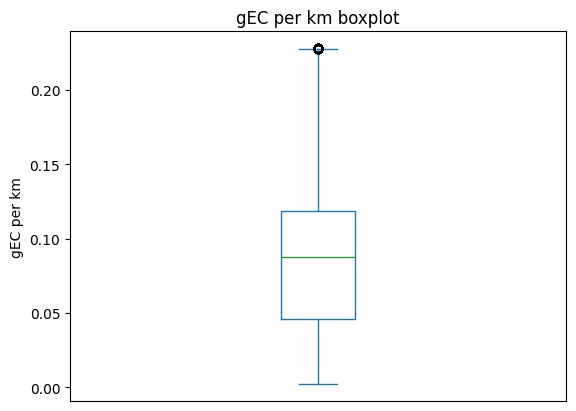

In [34]:
# boxplot of gEC per km
df['gec_per_km'].plot(kind='box')
plt.ylabel('gEC per km')
plt.title('gEC per km boxplot')
plt.xticks([])

Correlation coefficient: 0.701
Equation of trendline:  
0.2782 x - 316.8


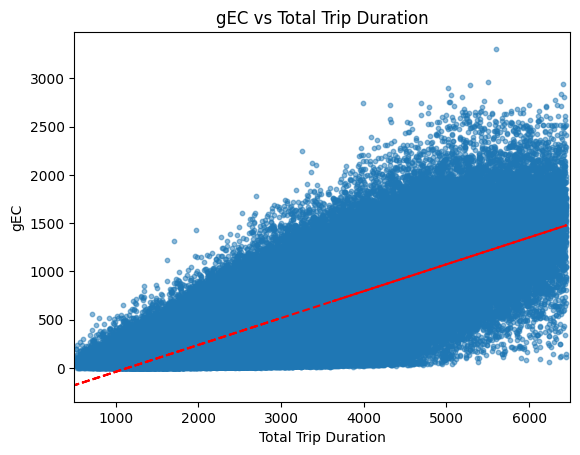

In [35]:
# plot gEC vs total_duration
plt.scatter(df['total_duration'], df['gec'], alpha=0.5, s=10)
plt.xlabel('Total Trip Duration')
plt.ylabel('gEC')
plt.title('gEC vs Total Trip Duration')

# trendline with correlation coefficient
z = np.polyfit(df['total_duration'], df['gec'], 1)
p = np.poly1d(z)
plt.plot(df['total_duration'],p(df['total_duration']),"r--")
plt.xlim(500, 6500)
plt.savefig('out/gec/gEC_vs_total_duration.png')
print('Correlation coefficient:', round(np.corrcoef(df['total_duration'], df['gec'])[0, 1], 3))
print('Equation of trendline:', p)

Correlation coefficient: 0.468
Equation of trendline:  
54.36 x + 201.9


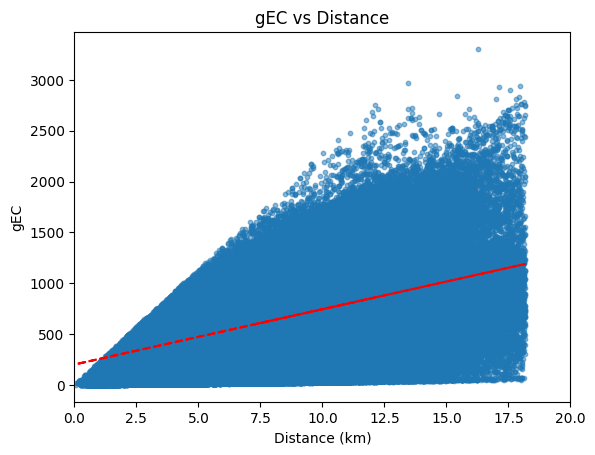

In [49]:
# gEC vs distance
plt.scatter(df['distance'], df['gec'], alpha=0.5, s=10)
plt.xlabel('Distance (km)')
plt.ylabel('gEC')
plt.title('gEC vs Distance')

# trendline with correlation coefficient
z = np.polyfit(df['distance'], df['gec'], 1)
p = np.poly1d(z)
plt.plot(df['distance'],p(df['distance']),"r--")
print('Correlation coefficient:', round(np.corrcoef(df['distance'], df['gec'])[0, 1], 3))
print('Equation of trendline:', p)
plt.xlim(0, 20)
plt.savefig('out/gec/gEC_vs_distance.png')

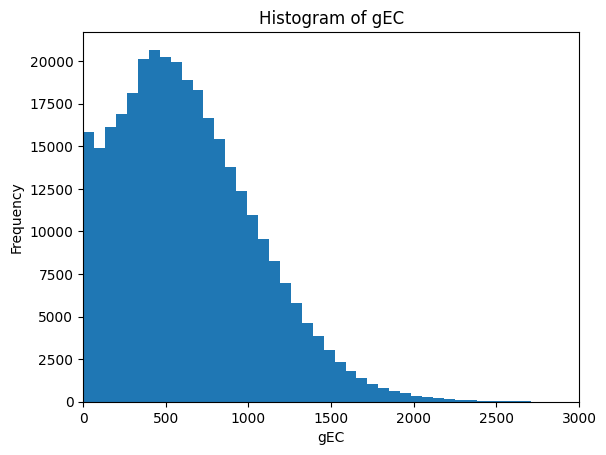

In [36]:
# histogram of gEC
plt.clf()
plt.hist(gEC, bins=50)
plt.xlabel('gEC')
plt.xlim(0, 3000)
plt.ylabel('Frequency')
plt.title('Histogram of gEC')
plt.savefig('out/gec/histogram_of_gEC.png')

In [37]:
# plot gEC vs hour of day
start_times = []
for row in df['start_datetime']:
    # HHMMSS
    time = int(row.split('T')[1])
    time = time // 10000
    start_times.append(time)
    
# start_times

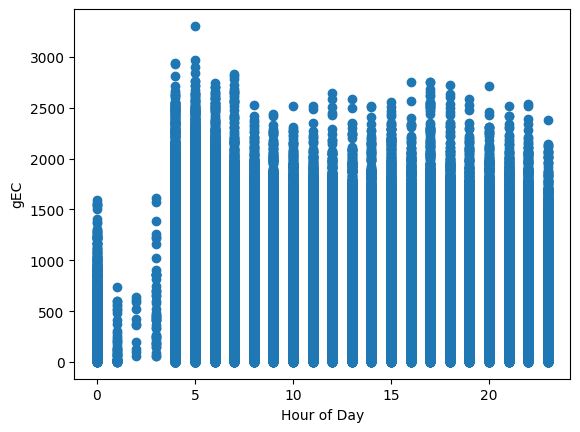

In [38]:
plt.scatter(start_times, gEC)
plt.xlabel('Hour of Day')
plt.ylabel('gEC')
plt.savefig('out/gec/gEC_vs_hour_of_day.png')
plt.show()